In [1]:
library(tidyverse)
options("readr.show_col_types"=F)

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [36]:
meta = read_tsv("alleuc_all_metadata.tsv")[] %>%
    mutate(
        species = sub('camadulensis', 'camaldulensis', species),
        species = sub(' x (Eucalyptus )?', 'X', species),
        species_only = gsub("(\\S+ .+?) ?(X|subsp\\.| ?\\(|\\?|/).*", "\\1", species, perl=T) %>% sub("Eucalyptus ", "E.", .),
        species_other = ifelse(as.numeric(table(species_only)[species_only]) > 10, species_only, "Other"),
    )

In [37]:
meta %>%
    count(species_other) %>%
    arrange(-n) %>%
    kview() 

In [38]:
fqstat = read_tsv("all_fastq_sumstats.tsv", col_names = c("checksum", "fqfile", "n_reads", "n_bases"))

In [39]:
metafq = meta %>%
    pivot_longer(read1:interleaved, names_to="read", values_to="fqfile") %>%
    left_join(fqstat, by=join_by(fqfile))
str(metafq)

tibble [24,441 × 37] (S3: tbl_df/tbl/data.frame)
 $ library        : chr [1:24441] "A_acuminata_ANBG_1" "A_acuminata_ANBG_1" "A_acuminata_ANBG_1" "A_acuminata_ANBG_2" ...
 $ sample         : chr [1:24441] "Acacia_acuminata_ANBG" "Acacia_acuminata_ANBG" "Acacia_acuminata_ANBG" "Acacia_acuminata_ANBG" ...
 $ project        : chr [1:24441] "AcaciaPan" "AcaciaPan" "AcaciaPan" "AcaciaPan" ...
 $ seq_date       : chr [1:24441] "2020-01" "2020-01" "2020-01" "2020-01" ...
 $ species        : chr [1:24441] NA NA NA NA ...
 $ date           : Date[1:24441], format: NA NA ...
 $ parsed_date    : Date[1:24441], format: NA NA ...
 $ latitude       : num [1:24441] NA NA NA NA NA NA NA NA NA NA ...
 $ longitude      : num [1:24441] NA NA NA NA NA NA NA NA NA NA ...
 $ elevation      : num [1:24441] NA NA NA NA NA NA NA NA NA NA ...
 $ datum          : chr [1:24441] NA NA NA NA ...
 $ location       : chr [1:24441] NA NA NA NA ...
 $ collectors     : chr [1:24441] NA NA NA NA ...
 $ samplename     : c

In [40]:
dntax = read_csv("https://github.com/borevitzlab/cca-eucs/raw/master/metadata/originals/DNTaxonomyCleaned.csv")

In [41]:
str(dntax)

spc_tbl_ [1,159 × 8] (S3: spec_tbl_df/tbl_df/tbl/data.frame)
 $ Binomial  : chr [1:1159] "Angophora costata" "Angophora costata subsp. euryphylla" "Angophora costata subsp. costata" "Angophora leiocarpa" ...
 $ Genus     : chr [1:1159] "Angophora" "Angophora" "Angophora" "Angophora" ...
 $ Subgenus  : chr [1:1159] NA NA NA NA ...
 $ Section   : chr [1:1159] NA NA NA NA ...
 $ Series    : chr [1:1159] "'Costatitae' ms" "'Costatitae' ms" "'Costatitae' ms" "'Costatitae' ms" ...
 $ Subseries : chr [1:1159] NA NA NA NA ...
 $ Species   : chr [1:1159] "costata" "costata" "costata" "leiocarpa" ...
 $ Subspecies: chr [1:1159] NA "euryphylla" "costata" NA ...
 - attr(*, "spec")=
  .. cols(
  ..   Binomial = col_character(),
  ..   Genus = col_character(),
  ..   Subgenus = col_character(),
  ..   Section = col_character(),
  ..   Series = col_character(),
  ..   Subseries = col_character(),
  ..   Species = col_character(),
  ..   Subspecies = col_character()
  .. )
 - attr(*, "problems")=<exte

In [49]:
mfq.sum = metafq %>%
    group_by(sample, project, species, species_other, date, latitude, longitude) %>%
    summarise(
        n_libs=n_distinct(library),
        n_runs=n_distinct(paste(seqproject, lanedir)),
        n_reads=sum(n_reads, na.rm=T),
        n_bases=sum(n_bases, na.rm=T),
    ) %>%
    ungroup() %>%
    mutate(
        sample=fct_reorder2(sample, species_other, n_bases, .na_rm =F),
    ) %>%
    left_join(
        dntax %>% select(Binomial, Section),
        by=join_by(species==Binomial)
    )

`summarise()` has grouped output by 'sample', 'project', 'species', 'species_other', 'date', 'latitude'. You can override using the `.groups` argument.


In [59]:
plotby = function(df, key) {
    p = ggplot(df, aes(x=sample, y=n_bases/600e6)) +
        geom_bar(aes(fill=species_other), stat="identity") +
        theme_bw() +
        labs(y="Theoretical Coverage", x="Sample",  fill="Species", title=sprintf("%s (%d spp.)", key, n_distinct(df$species_other))) +
        guides(fill=guide_legend(nrow=3)) +
        theme(
            legend.position="bottom",
            panel.grid.major.x=element_blank(),
            axis.text.x=element_blank(),
        )
    print(p)
    ggsave(sprintf("plot/%s_sample_coverages.png", key), width=2+0.02*nrow(df), height=5, plot=p)
    ggsave(sprintf("plot/%s_sample_coverages.pdf", key), width=2+0.02*nrow(df), height=5, plot=p)
    
    p = ggplot(df, aes(x=n_bases/600e6)) +
        geom_histogram(aes(fill=species_other)) +
        theme_bw() +
        labs(x="Theoretical Coverage", x="# Samples", fill="Species", title=sprintf("%s (%d spp.)", key, n_distinct(df$species_other))) +
        #guides(fill=guide_legend(nrow=3)) +
        theme(
            legend.position="bottom",
        )
    print(p)
    ggsave(sprintf("plot/%s_coverhist.png", key), width=8, height=6, plot=p)
    ggsave(sprintf("plot/%s_coverhist.pdf", key), width=8, height=6, plot=p)
}

In [60]:
mfq.sum %>%
    count(Section) %>%
    arrange(n)

Section,n
<chr>,<int>
Inclusae,1
Naviculares,1
Platysperma,1
Pumilio,1
Sejunctae,1
'Frutices' ms,2
Abbreviatae,2
Bolites,2
Incognitae,2


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


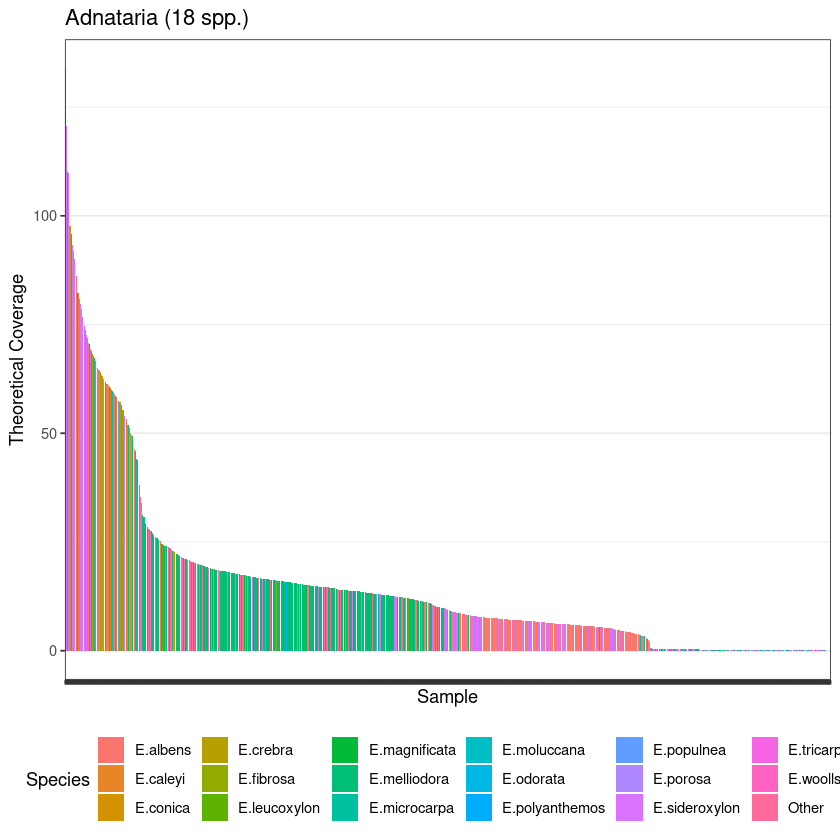

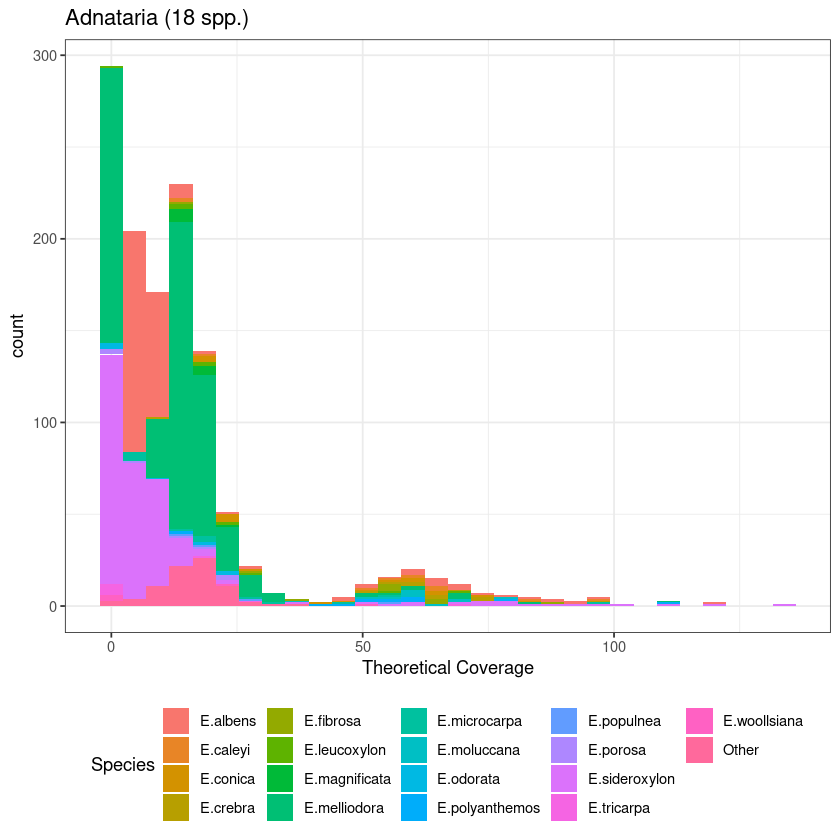

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


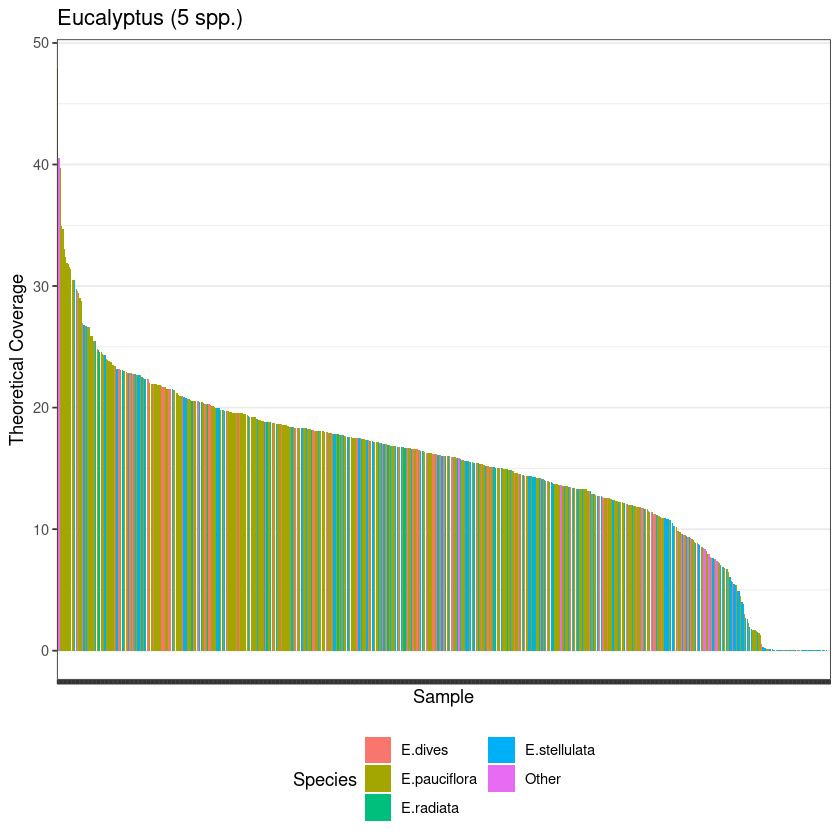

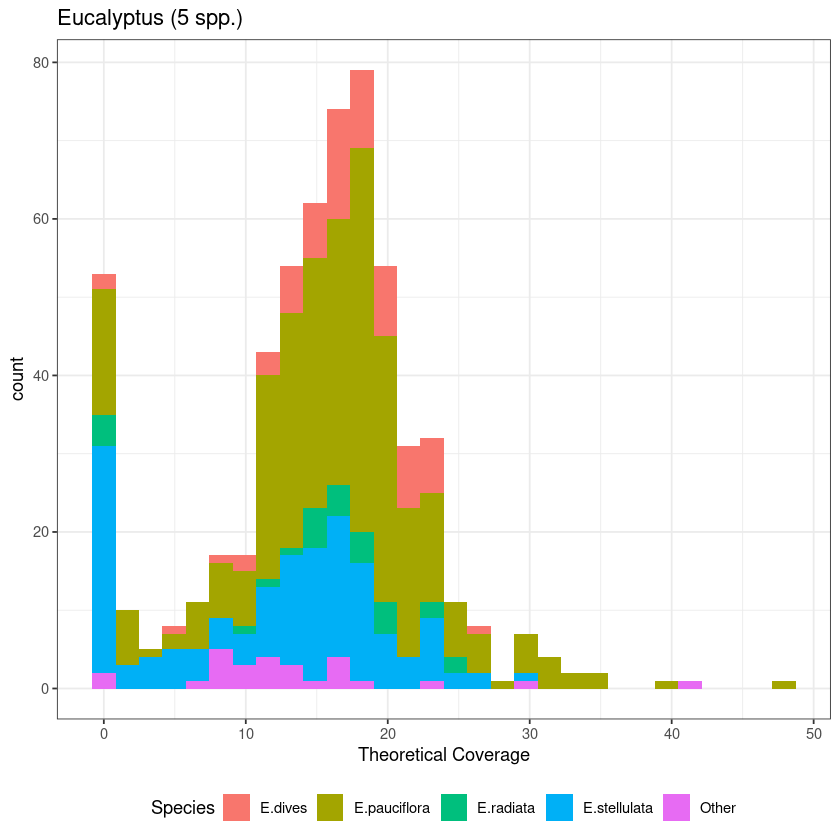

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


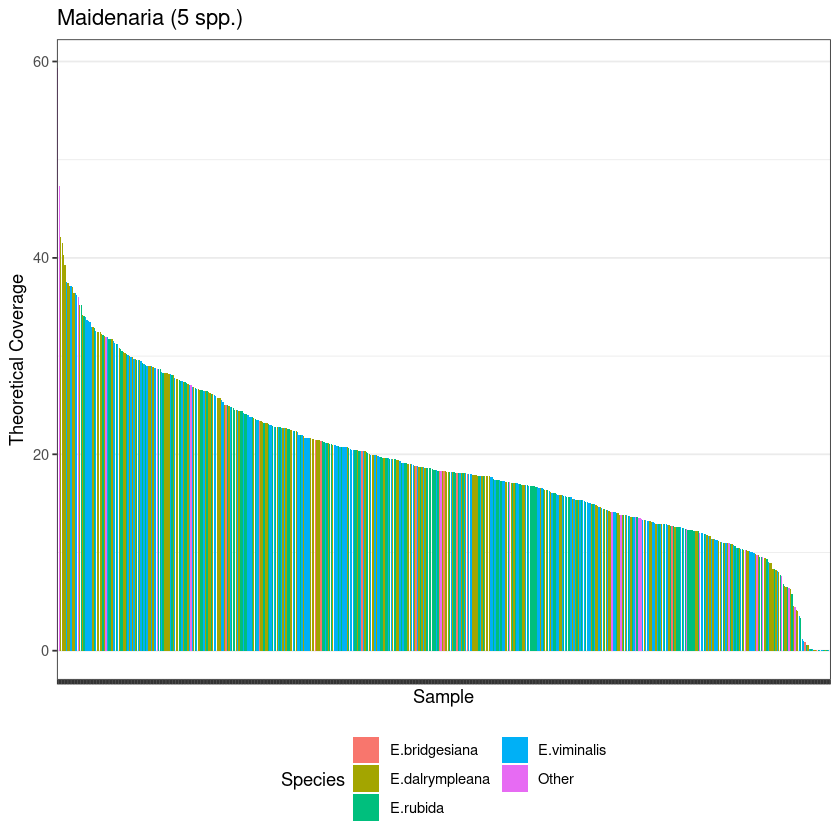

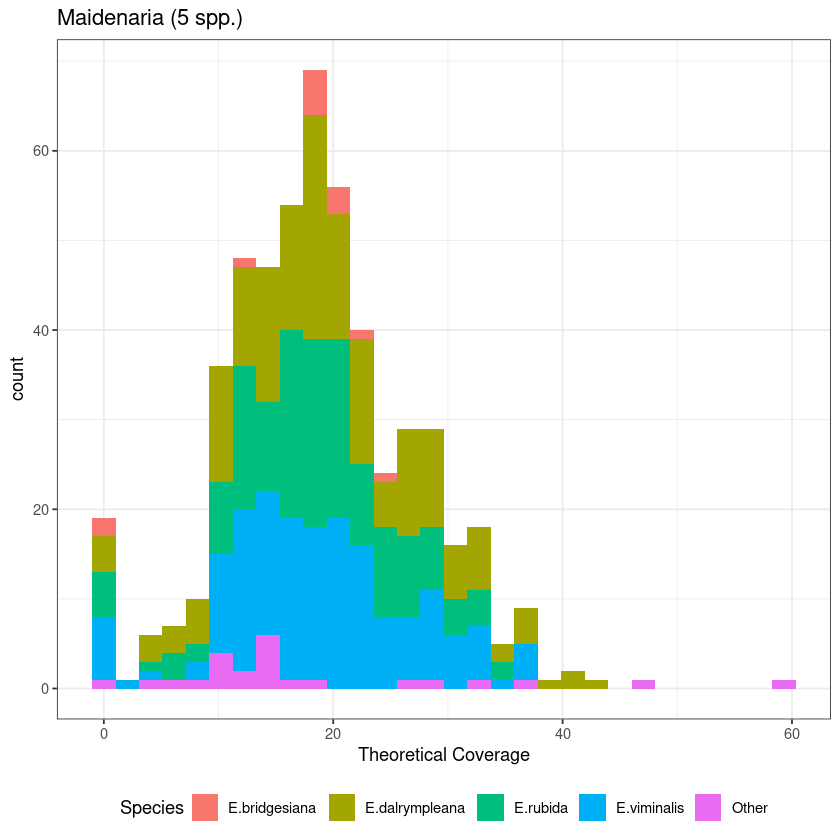

In [61]:
mfq.sum %>%
filter(Section %in% c("Adnataria", "Eucalyptus", "Maidenaria")) %>%
group_by(Section) %>%
group_walk(plotby)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


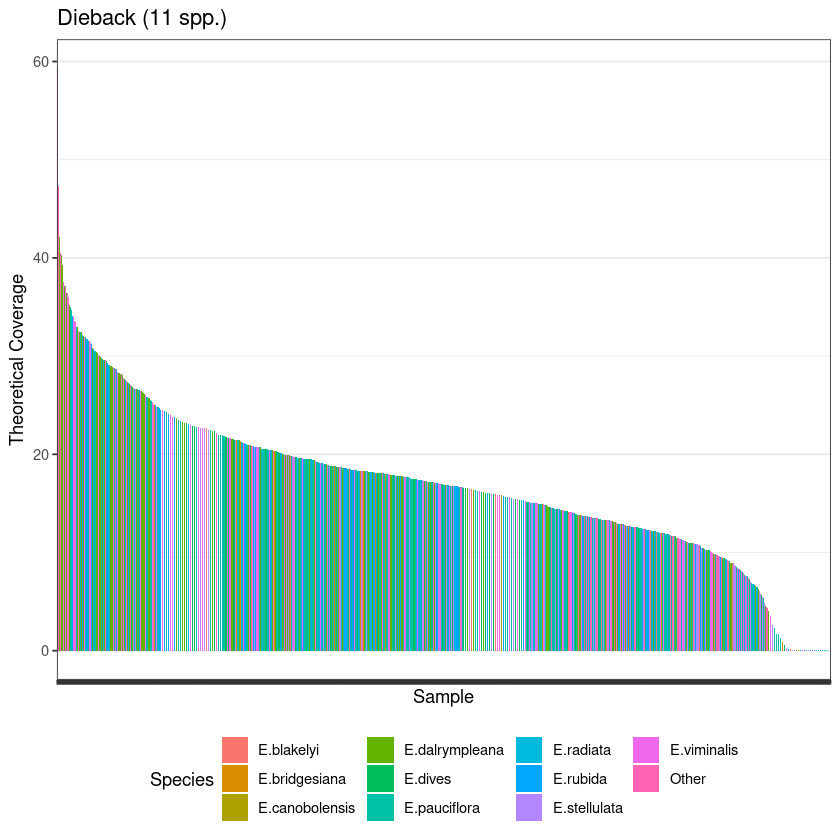

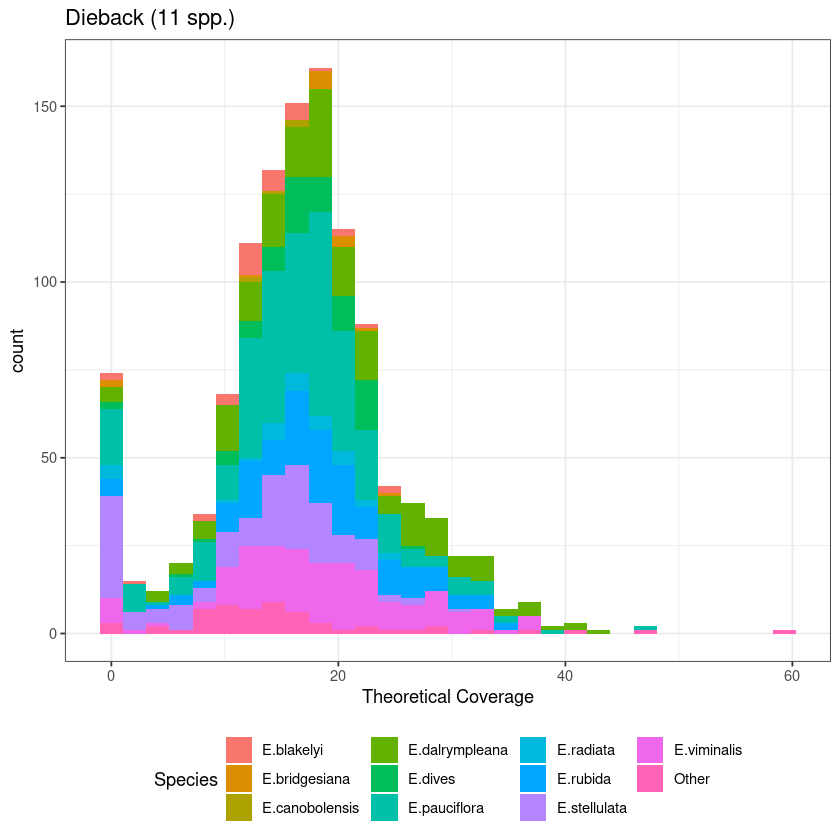

In [62]:
db = mfq.sum %>%
mutate(project=ifelse(Section%in%c("Maidenaria", "Eucalyptus") | project=="MMackinnon", "Dieback", NA)) %>%
filter(project=="Dieback", !is.na(species_other))

db %>%
group_by(project) %>%
group_walk(plotby)

In [63]:
dbsamp = db %>%
    pull(sample) %>%
    as.character()
writeLines(dbsamp, "dieback_samples.txt")

In [55]:
dbfq = meta %>%
    filter(sample %in% dbsamp)  %>%
    select(library, sample, read1, read2, interleaved)

In [27]:
write_tsv(dbfq, "dieback_only.tsv", na="")